### Acousticbrainz classifier patterns
Notebook **acousticbrainz_stability** showed that a many of the classifiers are relatively unstable, and that correlation between classifiers modeling the same concept is not as high as would be expected. Those correlation plots showed interesting patterns, which will be further explored here.

In [20]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 15)})

from tqdm.notebook import tqdm
tqdm().pandas()


# Load in the acousticbrainz dataset into the variable 'acousticbrainz'
acousticbrainz = pd.read_hdf(Path.cwd() / 'datasets' / 'acousticbrainzV3.h5')

acousticbrainz['mbid'] = acousticbrainz.index.get_level_values(0)

C:\Users\Chris\Miniconda3\envs\thesis\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


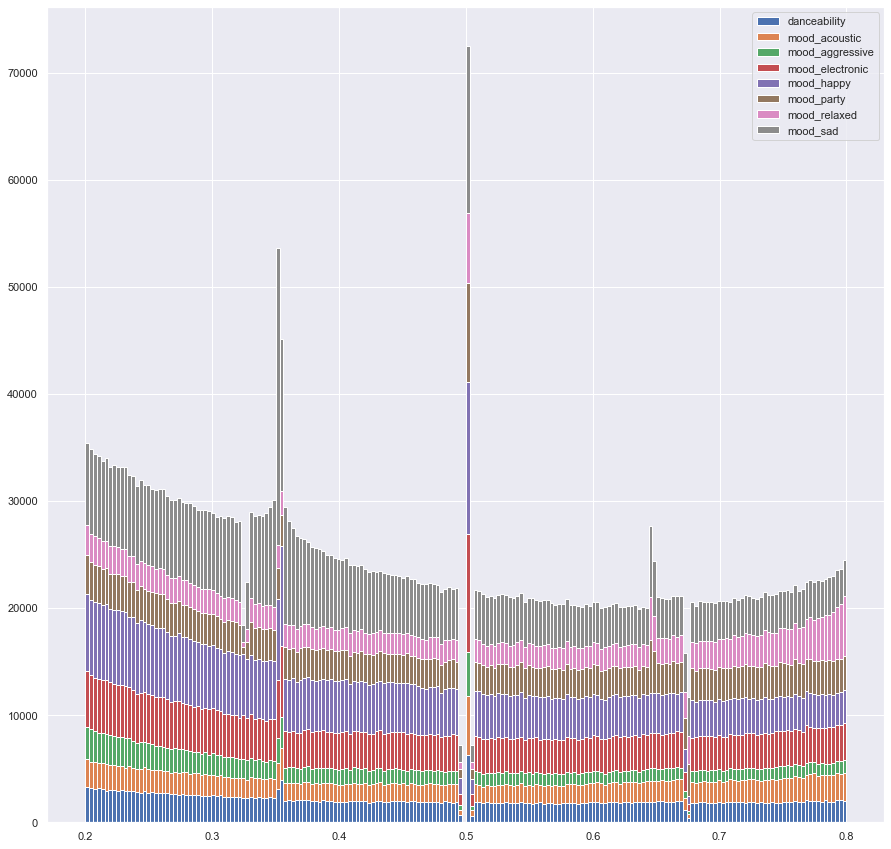

In [2]:
# List of columns to inspect, binary 'mood' features. Positive class is always chosen
toSelect = [('danceability', 'danceable'), ('mood_acoustic', 'acoustic'),
       ('mood_aggressive', 'aggressive'), ('mood_electronic', 'electronic'),
       ('mood_happy', 'happy'), ('mood_party', 'party'),
       ('mood_relaxed', 'relaxed'), ('mood_sad', 'sad')]


fig = plt.figure()
ax = fig.gca()

cols = [acousticbrainz[x] for x in toSelect]
filtered = [col[(col > 0.2) & (col < 0.8)] for col in cols]
labels = [x[0] for x in toSelect]

ax.hist(filtered, bins=200, stacked=True, label=labels)
ax.legend()

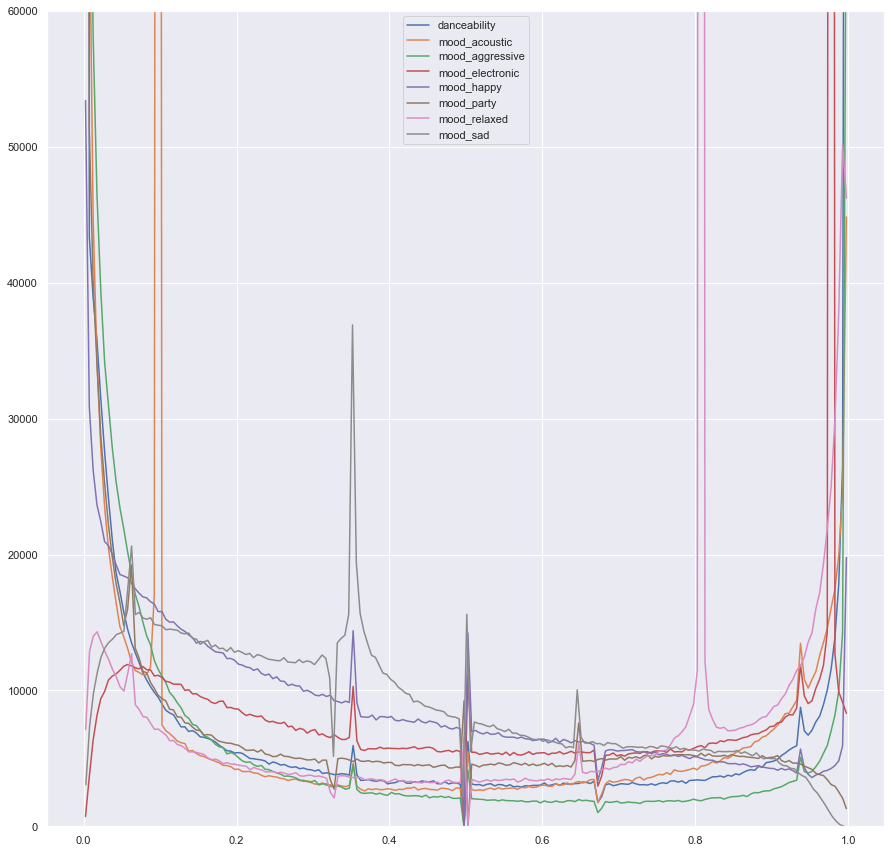

In [3]:
fig = plt.figure()
plt.ylim(top=60000)

for i in range(0, len(cols)):
    y,binEdges = np.histogram(cols[i],bins=200)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    plt.plot(bincenters, y, label=labels[i])

plt.legend()
plt.show()
    

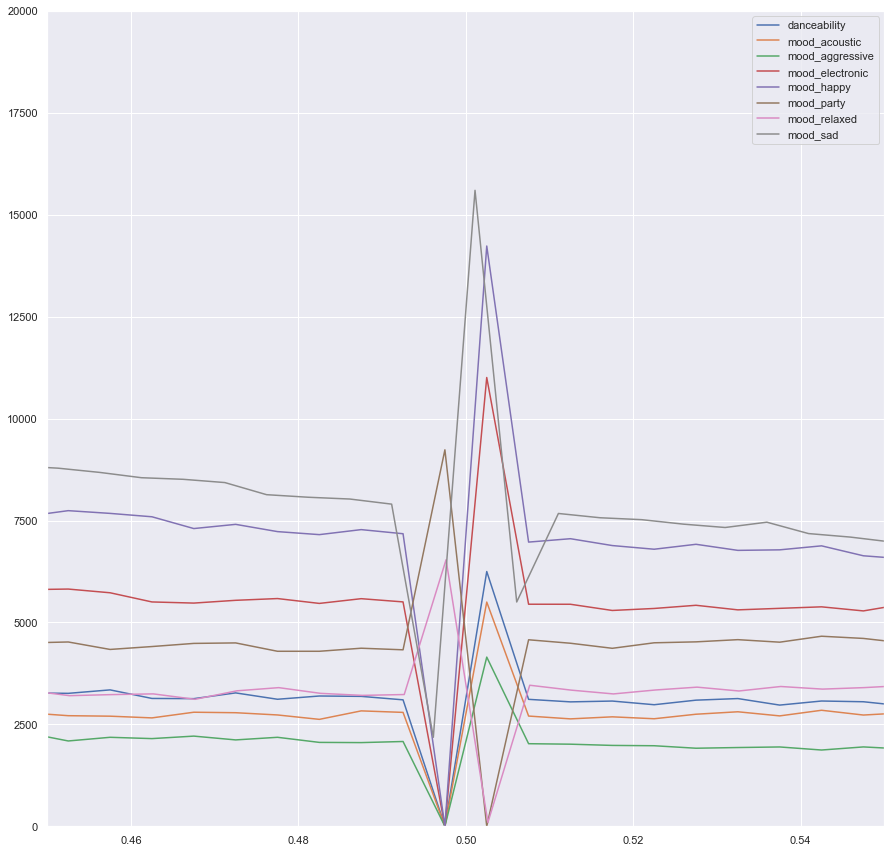

In [4]:
fig = plt.figure()
plt.xlim(0.45, 0.55)
plt.ylim(top=20000)

for i in range(0, len(cols)):
    y,binEdges = np.histogram(cols[i],bins=200)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    plt.plot(bincenters, y, label=labels[i])

plt.legend()
plt.show()

Now, we wish to investigate these spikes and dips a bit more, first we consider that metadata like bitrate or the essentia version used to extract might explain these peaks:

In [5]:
# Spike in acousticness at 0.09 - 0.10
acoust_spike = acousticbrainz[acousticbrainz[('mood_acoustic', 'acoustic')].between(0.09, 0.10, inclusive=True)]

# Spike in mood relaxed at 0.805 - 0.815
relaxed_spike = acousticbrainz[acousticbrainz[('mood_relaxed', 'relaxed')].between(0.805, 0.815, inclusive=True)]

# Spike in mood electronic at 0.972 - 0.982
electronic_spike = acousticbrainz[acousticbrainz[('mood_electronic', 'electronic')].between(0.972, 0.982, inclusive=True)]

# Small spike in sad, party, electronic, danceability, acoustic, aggressive at 0.346 - 0.362
combined_spike = acousticbrainz[acousticbrainz[('mood_sad', 'sad')].between(0.346, 0.362, inclusive=True)]

# Small dip in sad, party, relaxed at 0.317 - 0.3317
combined_dip = acousticbrainz[acousticbrainz[('mood_sad', 'sad')].between(0.317, 0.3317, inclusive=True)]


# Check if any pattern in the amount of lossless songs:
loss_full = acousticbrainz['lossless'].value_counts(normalize=True)
loss_acoust_spike = acoust_spike['lossless'].value_counts(normalize=True)
loss_relaxed_spike = relaxed_spike['lossless'].value_counts(normalize=True)
loss_electronic_spike = electronic_spike['lossless'].value_counts(normalize=True)
loss_combined_spike = combined_spike['lossless'].value_counts(normalize=True)
loss_combined_dip = combined_dip['lossless'].value_counts(normalize=True)

lossless_stats = pd.DataFrame([loss_full[1], loss_acoust_spike[1], loss_relaxed_spike[1],
                               loss_electronic_spike[1], loss_combined_spike[1], loss_combined_dip[1]],
            index=['Full', 'Acoustic spike', 'Relaxed spike', 'Electronic spike', 'Combined spike', 'Combined dip'],
            columns = ['Percentage lossless'])

display(lossless_stats)

# Check if any pattern in the codec of the songs:
codec_full = acousticbrainz['codec'].value_counts(normalize=True)
codec_acoust_spike = acoust_spike['codec'].value_counts(normalize=True)
codec_relaxed_spike = relaxed_spike['codec'].value_counts(normalize=True)
codec_electronic_spike = electronic_spike['codec'].value_counts(normalize=True)
codec_combined_spike = combined_spike['codec'].value_counts(normalize=True)
codec_combined_dip = combined_dip['codec'].value_counts(normalize=True)

codec_stats = pd.DataFrame([codec_full, codec_acoust_spike, codec_relaxed_spike,
                               codec_electronic_spike, codec_combined_spike, codec_combined_dip],
            index=['Full', 'Acoustic spike', 'Relaxed spike', 'Electronic spike', 'Combined spike', 'Combined dip'],)

display(codec_stats)

# Most versions are the same, however the essentia version for the low level features
# (used to calculate the high level features) does have some variation
ver_full = acousticbrainz['essentia_low'].value_counts(normalize=True)
ver_acoust_spike = acoust_spike['essentia_low'].value_counts(normalize=True)
ver_relaxed_spike = relaxed_spike['essentia_low'].value_counts(normalize=True)
ver_electronic_spike = electronic_spike['essentia_low'].value_counts(normalize=True)
ver_combined_spike = combined_spike['essentia_low'].value_counts(normalize=True)
ver_combined_dip = combined_dip['essentia_low'].value_counts(normalize=True)

ver_stats = pd.DataFrame([ver_full, ver_acoust_spike, ver_relaxed_spike,
                          ver_electronic_spike, ver_combined_spike, ver_combined_dip],
                        index=['Full', 'Acoustic spike', 'Relaxed spike', 'Electronic spike', 'Combined spike', 'Combined dip'])

display(ver_stats)


,Percentage lossless
Full,0.325822
Acoustic spike,0.105501
Relaxed spike,0.162542
Electronic spike,0.117786
Combined spike,0.364800
Combined dip,0.297760


,mp3,flac,vorbis,aac,alac,wmav2,mpc7,mp2,ape,wavpack,mpc8,mp1,wmapro
Full,0.598476,0.320427,0.039505,0.033874,0.005316,0.001802,0.000348,0.000096,0.000079,0.000068,0.000006,0.000001,5.537368e-07
Acoustic spike,0.844213,0.083374,0.028633,0.017084,0.022121,0.004125,0.000137,0.000089,0.000006,0.000195,0.000022,NaN,NaN
Relaxed spike,0.783913,0.144755,0.031341,0.018086,0.017748,0.003685,0.000165,0.000091,0.000039,0.000159,0.000019,NaN,NaN
Electronic spike,0.832754,0.097053,0.029009,0.016009,0.020728,0.004023,0.000110,0.000095,0.000005,0.000192,0.000022,NaN,NaN
Combined spike,0.570315,0.361550,0.032647,0.027785,0.003250,0.003686,0.000370,0.000119,NaN,0.000277,NaN,NaN,NaN
Combined dip,0.628357,0.293620,0.038604,0.033120,0.004105,0.001522,0.000602,0.000035,0.000035,NaN,NaN,NaN,NaN


,2.1-beta2,2.1-beta1
Full,0.632393,0.367607
Acoustic spike,0.112207,0.887793
Relaxed spike,0.197968,0.802032
Electronic spike,0.125277,0.874723
Combined spike,0.637921,0.362079
Combined dip,0.647075,0.352925


In [22]:
# Spike in acousticness at 0.09 - 0.10
acoust_spike = acousticbrainz[acousticbrainz[('mood_acoustic', 'acoustic')].between(0.09, 0.10, inclusive=True)]
acoust_rest_low = acousticbrainz[acousticbrainz[('mood_acoustic', 'acoustic')].between(0.00, 0.09, inclusive=False)]
acoust_rest_high = acousticbrainz[acousticbrainz[('mood_acoustic', 'acoustic')].between(0.10, 1.00, inclusive=False)]

acoust_spike['label'] = 'anomaly'
acoust_rest_low['label'] = 'non-anomaly'
acoust_rest_high['label'] = 'non-anomaly'

acoust_anomalies = pd.concat([acoust_spike, acoust_rest_low, acoust_rest_high])
acoust_anomalies = acoust_anomalies[['codec', 'bit_rate', 'essentia_low', 'essentia_git_sha_low', 'essentia_build_sha_low', 'label']]
acoust_anomalies.to_csv('acousticness_anomalies.csv')

# Spike in mood relaxed at 0.805 - 0.815
relaxed_spike = acousticbrainz[acousticbrainz[('mood_relaxed', 'relaxed')].between(0.805, 0.815, inclusive=True)]
relaxed_spike_low = acousticbrainz[acousticbrainz[('mood_relaxed', 'relaxed')].between(0.00, 0.805, inclusive=False)]
relaxed_spike_high = acousticbrainz[acousticbrainz[('mood_relaxed', 'relaxed')].between(0.815, 1.00, inclusive=False)]

relaxed_spike['label'] = 'anomaly'
relaxed_spike_low['label'] = 'non-anomaly'
relaxed_spike_high['label'] = 'non-anomaly'

relaxed_anomalies = pd.concat([relaxed_spike, relaxed_spike_low, relaxed_spike_high])
relaxed_anomalies = relaxed_anomalies[['codec', 'bit_rate', 'essentia_low', 'essentia_git_sha_low', 'essentia_build_sha_low', 'label']]
relaxed_anomalies.to_csv('relaxed_anomalies.csv')

# Spike in mood electronic at 0.972 - 0.982
electronic_spike = acousticbrainz[acousticbrainz[('mood_electronic', 'electronic')].between(0.972, 0.982, inclusive=True)]
electronic_spike_low = acousticbrainz[acousticbrainz[('mood_electronic', 'electronic')].between(0.00, 0.972, inclusive=False)]
electronic_spike_high = acousticbrainz[acousticbrainz[('mood_electronic', 'electronic')].between(0.982, 1.00, inclusive=False)]

electronic_spike['label'] = 'anomaly'
electronic_spike_low['label'] = 'non-anomaly'
electronic_spike_high['label'] = 'non-anomaly'

electronic_anomalies = pd.concat([electronic_spike, electronic_spike_low, electronic_spike_high])
electronic_anomalies = electronic_anomalies[['codec', 'bit_rate', 'essentia_low', 'essentia_git_sha_low', 'essentia_build_sha_low', 'label']]
electronic_anomalies.to_csv('electronic_anomalies.csv')


C:\Users\Chris\Miniconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Chris\Miniconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Chris\Miniconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [6]:
from scipy.stats import chi2_contingency
from scipy.stats import chisquare
from scipy.spatial.distance import jensenshannon

# Spike in acousticness at 0.09 - 0.10
acoust_spike_filt = acousticbrainz[('mood_acoustic', 'acoustic')].between(0.09, 0.10, inclusive=True)

# Spike in mood relaxed at 0.805 - 0.815
relaxed_spike_filt = acousticbrainz[('mood_relaxed', 'relaxed')].between(0.805, 0.815, inclusive=True)

# Spike in mood electronic at 0.972 - 0.982
electronic_spike_filt = acousticbrainz[('mood_electronic', 'electronic')].between(0.972, 0.982, inclusive=True)

# Small spike in sad, party, electronic, danceability, acoustic, aggressive at 0.346 - 0.362
combined_spike_filt = acousticbrainz[('mood_sad', 'sad')].between(0.346, 0.362, inclusive=True)

# Small dip in sad, party, relaxed at 0.317 - 0.3317
combined_dip_filt = acousticbrainz[('mood_sad', 'sad')].between(0.317, 0.3317, inclusive=True)

# Random part for comparison sake
random_filt = acousticbrainz[('mood_sad', 'sad')].between(0.22, 0.24, inclusive=True)

filts = [acoust_spike_filt, relaxed_spike_filt, electronic_spike_filt, combined_spike_filt, combined_dip_filt, random_filt]
filtnames = ['Acoustic spike', 'Relaxed spike', 'Electronic spike', 'Combined spike', 'Combined dip', 'Random non-spike']
variables = ['lossless', 'essentia_low']

def get_chi2(filt, variable):
    # 'Rest' of the distribution
    #a = acousticbrainz[variable].value_counts().to_numpy()
    a = acousticbrainz[~filt][variable].value_counts().to_numpy()
    # Part of the distribution we are interested in
    b = acousticbrainz[filt][variable].value_counts().to_numpy()
    
    c = np.array([a,b])
    
    return chi2_contingency(c)

def get_shannondist(filt, variable):
    # 'Rest' of the distribution
    #a = acousticbrainz[variable].value_counts().to_numpy()
    a = acousticbrainz[~filt][variable].value_counts().to_numpy()
    # Part of the distribution we are interested in
    b = acousticbrainz[filt][variable].value_counts().to_numpy()
    
    return jensenshannon(a, b)

for var in variables:
    print(f"\n{var}:\n")
    for i in range(0, len(filts)):
        print(filtnames[i])
        statistic = get_chi2(filts[i], var)
        dist = get_shannondist(filts[i], var)
        print(f"Chi-squared:{statistic[0]}, p:{statistic[1]}")
        print(f"Shannon distance: {dist}\n")


lossless:

Acoustic spike
Chi-squared:98928.22436258738, p:0.0
Shannon distance: 0.2320300922874481

Relaxed spike
Chi-squared:80518.02466358009, p:0.0
Shannon distance: 0.17893502606267417

Electronic spike
Chi-squared:101605.87067511733, p:0.0
Shannon distance: 0.22238992546616426

Combined spike
Chi-squared:546.2124274419529, p:8.393559732047731e-121
Shannon distance: 0.030275881239370313

Combined dip
Chi-squared:102.7943733425642, p:3.718040211220218e-24
Shannon distance: 0.02175716516107658

Random non-spike
Chi-squared:537.8269254737656, p:5.599922749163977e-119
Shannon distance: 0.037899498065854006


essentia_low:

Acoustic spike
Chi-squared:27369.68145611925, p:0.0
Shannon distance: 0.11865617695371047

Relaxed spike
Chi-squared:219.51015109220828, p:1.1567317539839777e-49
Shannon distance: 0.008832583721705716

Electronic spike
Chi-squared:18466.75485640079, p:0.0
Shannon distance: 0.09144513645197444

Combined spike
Chi-squared:10.361693054794163, p:0.0012865715746953098
S

The essentia version used for *all* high level feature calculation was 2.1-beta1, however for the low level feature extraction both 2.1-beta1 and 2.1-beta2 were used. The three large spikes for the single classifier correspond with an increased amount of low level features extracted with 2.1-beta1 compared to the full range of probabilities.

Perhaps some bug in the low-level feature extraction in 2.1-beta1 causes these large spikes?

Metadata for the smaller spikes with multiple classifiers can not really be explained by either the versioning or the quality, thus we will also take a look at genre data to see if there might be a bias in the underlying data causing these spikes.

In [7]:
# We have three 'ground truth sources' for genre: discogs, lastfm and tagtraum
discogs = pd.read_table(Path.cwd() / 'datasets' / 'acousticbrainz_genres' / 'acousticbrainz-mediaeval2017-discogs-train.tsv')
lastfm = pd.read_table(Path.cwd() / 'datasets' / 'acousticbrainz_genres' / 'acousticbrainz-mediaeval2017-lastfm-train.tsv')
tagtraum = pd.read_table(Path.cwd() / 'datasets' / 'acousticbrainz_genres' / 'acousticbrainz-mediaeval2017-tagtraum-train.tsv')

C:\Users\Chris\Miniconda3\envs\thesis\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (17,18,19,20,21,22,23,24,25,26,27,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Chris\Miniconda3\envs\thesis\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
import math

def get_genre_counts(data, genres, lab):
    d = data.merge(genres, left_on='mbid', right_on='recordingmbid')
    cols = [col for col in d.columns if 'genre' in col]
    counts = {}

    for col in cols:
        for val in d[col]:
            # Main genre
            if isinstance(val, str) and ("---" not in val):
                try:
                    counts[val] += 1
                except:
                    counts[val] = 1

    return pd.DataFrame([counts], index=[lab])


discogs_counts = pd.DataFrame()
lastfm_counts = pd.DataFrame()
tagtraum_counts = pd.DataFrame()

discogs_rest_counts = pd.DataFrame()
lastfm_rest_counts = pd.DataFrame()
tagtraum_rest_counts = pd.DataFrame()

for i in range(0, len(filts)):
    discogs_counts = discogs_counts.append(get_genre_counts(acousticbrainz[filts[i]], discogs, filtnames[i]))
    #discogs_rest_counts = discogs_rest_counts.append(get_genre_counts(acousticbrainz, discogs, filtnames[i]))
    discogs_rest_counts = discogs_rest_counts.append(get_genre_counts(acousticbrainz[~filts[i]], discogs, filtnames[i]))
    lastfm_counts = lastfm_counts.append(get_genre_counts(acousticbrainz[filts[i]], lastfm, filtnames[i]))
    #lastfm_rest_counts = lastfm_rest_counts.append(get_genre_counts(acousticbrainz, lastfm, filtnames[i]))
    lastfm_rest_counts = lastfm_rest_counts.append(get_genre_counts(acousticbrainz[~filts[i]], lastfm, filtnames[i]))
    tagtraum_counts = tagtraum_counts.append(get_genre_counts(acousticbrainz[filts[i]], tagtraum, filtnames[i]))
    #tagtraum_rest_counts = tagtraum_rest_counts.append(get_genre_counts(acousticbrainz, tagtraum, filtnames[i]))
    tagtraum_rest_counts = tagtraum_rest_counts.append(get_genre_counts(acousticbrainz[~filts[i]], tagtraum, filtnames[i]))


C:\Users\Chris\Miniconda3\envs\thesis\lib\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Normalize the row counts so that we can compare more easily

In [9]:
counts = [discogs_counts, lastfm_counts, tagtraum_counts]
counts_names = ["Discogs", "LastFM", "TagTraum"]
counts_rest = [discogs_rest_counts, lastfm_rest_counts, tagtraum_rest_counts]

# Make sure that counts are available both in the peak/valley and in the rest of the data
for i in range(0, len(counts)):
    a = counts[i].dropna(axis=1)
    b = counts_rest[i].dropna(axis=1)
    
    cols = a.columns.intersection(b.columns)
    counts[i] = counts[i][cols]
    counts_rest[i] = counts_rest[i][cols]

for i in range(0, len(counts)):
    print(f"\n{counts_names[i]}:\n")
    for filt in filtnames:
        print(filt)
        a = counts[i].loc[filt].to_numpy()
        b = counts_rest[i].loc[filt].to_numpy()

        c = np.array([a,b])

        stat = chi2_contingency(c)
        dist = jensenshannon(a,b)
        print(f"Chi-Squared: {stat[0]}, p: {stat[1]}")
        print(f"Shannon dist: {dist}\n")



Discogs:

Acoustic spike
Chi-Squared: 10703.588311384294, p: 0.0
Shannon dist: 0.09011678710620305

Relaxed spike
Chi-Squared: 11023.46981470685, p: 0.0
Shannon dist: 0.08176769578853245

Electronic spike
Chi-Squared: 11164.842074861146, p: 0.0
Shannon dist: 0.08891854737403741

Combined spike
Chi-Squared: 4184.059212516462, p: 0.0
Shannon dist: 0.10858544491922274

Combined dip
Chi-Squared: 1073.2079375226474, p: 3.0291609659095518e-220
Shannon dist: 0.09169052509856773

Random non-spike
Chi-Squared: 2690.9505846234815, p: 0.0
Shannon dist: 0.1194903264978731


LastFM:

Acoustic spike
Chi-Squared: 10260.66478880508, p: 0.0
Shannon dist: 0.10841004784990778

Relaxed spike
Chi-Squared: 8758.661646650013, p: 0.0
Shannon dist: 0.09243241556646781

Electronic spike
Chi-Squared: 9985.473196710029, p: 0.0
Shannon dist: 0.10492653779304655

Combined spike
Chi-Squared: 4529.790722887224, p: 0.0
Shannon dist: 0.12962985978405372

Combined dip
Chi-Squared: 600.3633755817657, p: 5.41853591388651

# Visualizing the bitrate, codec and version distributions

C:\Users\Chris\Miniconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


AttributeError: 'list' object has no attribute 'keys'

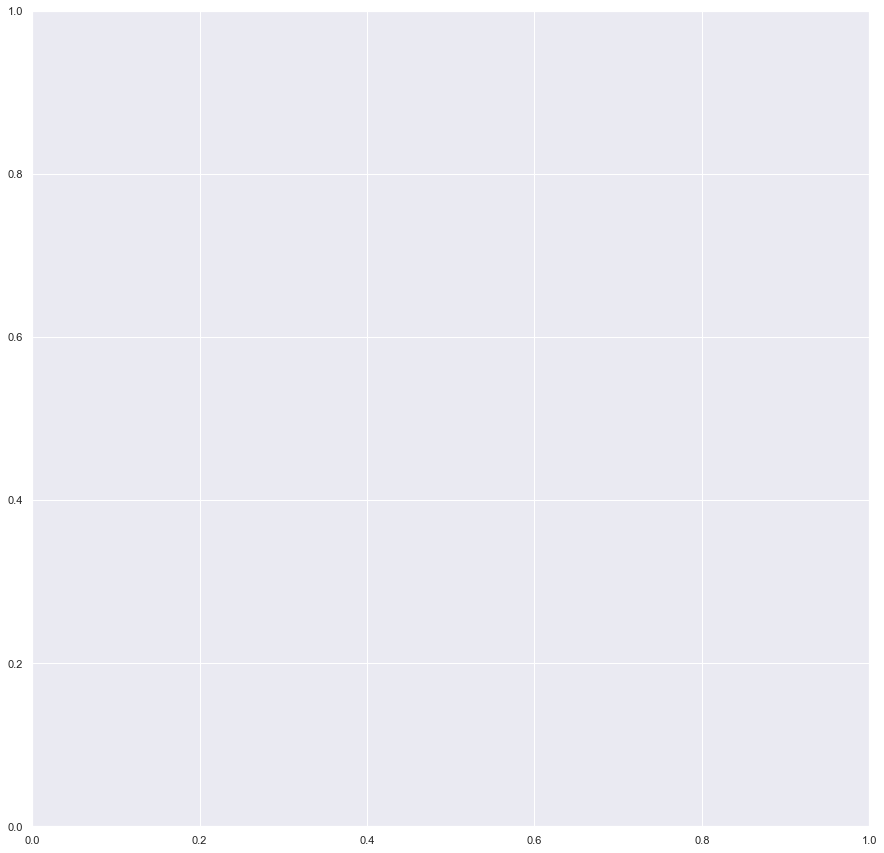

In [10]:
def do_plot_dist(classifier, bins):
    plot_dist(classifier, 'lossless', 1, bins, 'lossless')
    plot_dist(classifier, 'codec', 'mp3', bins, 'mp3')
    plot_dist(classifier, 'codec', 'vorbis', bins, 'vorbis')
    plot_dist(classifier, 'essentia_low', '2.1-beta1', bins, '2.1-beta1')
    plot_dist(classifier, 'bit_rate', 320000, bins, '320kbps')
    plot_dist(classifier, 'bit_rate', 128000, bins, '128kbps')
    plot_dist(classifier, 'bit_rate', 160000, bins, '160kbps')
    plot_dist(classifier, 'bit_rate', 192000, bins, '192kbps')
    plot_dist(classifier, 'bit_rate', 256000, bins, '256kbps')

def plot_dist(idx, col, value, bins, label):
    binned = pd.cut(acousticbrainz[idx], bins=bins, labels=False)

    val_count = {}
    total_count = {}

    for i in range(0, bins):
        val_count[i] = 0
        total_count[i] = 0

    for i in tqdm(range(0, len(binned))):
        idx = binned.index[i]
        b = binned.values[i]

        val = acousticbrainz.at[idx, col]
        if val == value:
            val_count[b] += 1
        total_count[b] += 1

    a = np.array(list(val_count.values()))
    b = np.array(list(total_count.values()))

    vals = np.nan_to_num(a/b)

    plt.plot([x/(bins-1) for x in counts.keys()], vals, label=label)

fig = plt.figure()
ax = fig.gca()

# Mood_acoustic
do_plot_dist(toSelect[1], 200)

plt.title("Fraction of entries with certain metadata for classifier values of mood_acoustic")
plt.xlabel("mood_acoustic value")
plt.ylabel("Metadata fraction")
plt.legend()
plt.show()